# Day High in 5m timeframe - Detection(Predict, Classification, Clustering)

### Import Library

In [5]:
import numpy as np
import pandas as pd
import numpy as np
import pandas_ta as ta
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 120
import warnings
warnings.filterwarnings('ignore')

### Load Price Data

In [6]:
import os
from pathlib import Path
notebook_path = os.getcwd()
current_dir = Path(notebook_path)
csv_file = str(current_dir) + '/VN30F1M_5minutes.csv'
is_file = os.path.isfile(csv_file)
if is_file:
    dataset = pd.read_csv(csv_file, index_col='Date', parse_dates=True)
else:
    print('remote')
    dataset = pd.read_csv("https://raw.githubusercontent.com/zuongthaotn/vn-stock-data/main/VN30ps/VN30F1M_5minutes.csv", index_col='Date', parse_dates=True)

In [7]:
data = dataset.copy()

In [8]:
data

,Open,High,Low,Close,Volume
Date,,,,,
2018-08-13 09:00:00,943.5,943.6,942.9,943.1,1812
2018-08-13 09:05:00,943.1,943.5,942.9,943.3,1323
2018-08-13 09:10:00,943.2,943.3,942.6,943.1,1207
2018-08-13 09:15:00,943.1,943.1,942.3,942.6,1196
2018-08-13 09:20:00,942.6,943.7,942.4,943.7,1765
...,...,...,...,...,...
2025-11-19 14:10:00,1891.5,1892.7,1890.9,1891.5,4627
2025-11-19 14:15:00,1891.4,1891.5,1885.5,1885.8,12293
2025-11-19 14:20:00,1885.8,1887.0,1878.0,1880.3,14371


In [9]:
def labeling_data(df):
    tmp_data = df.copy()
    tmp_data['DayHigh'] = tmp_data['High']
    daily_data = tmp_data.resample('D').agg({
            'DayHigh': 'max'
        })
    daily_data.dropna(subset=['DayHigh'], inplace=True)
    #
    data = df.copy()
    data = data.assign(time_d=pd.PeriodIndex(data.index, freq='1D').to_timestamp())
    #
    merged_data = pd.merge(data, daily_data, left_on="time_d", right_index=True, how="left")
    merged_data['hour'] = merged_data.index.hour
    merged_data['minute'] = merged_data.index.minute
    merged_data['prev_High'] = merged_data['High'].shift(1)
    merged_data['prev_Low'] = merged_data['Low'].shift(1)
    merged_data['prev_Close'] = merged_data['Close'].shift(1)
    merged_data['prev_Open'] = merged_data['Open'].shift(1)
    merged_data['prev_Vol'] = merged_data['Volume'].shift(1)
    merged_data['is_max'] = merged_data.apply(lambda r: 1 if r["High"] == r["DayHigh"] else 0, axis=1)
    ana_data = merged_data.dropna()
    ana_data['upper_shadow'] = ana_data.apply(lambda r: r["High"] - max(r["Open"], r["Close"]), axis=1)
    ana_data['prev_upper_shadow'] = ana_data['upper_shadow'].shift(1)
    ana_data['ibs'] = ana_data.apply(
        lambda r: 0 if r["High"] == r["Low"] else (r["Close"] - r["Low"]) / (r["High"] - r["Low"]), axis=1)
    ana_data['prev_ibs'] = ana_data['ibs'].shift(1)
    ana_data['RSI20'] = ta.rsi(ana_data["Close"], length=20)
    ana_data['RSI10'] = ta.rsi(ana_data["Close"], length=10)
    ana_data['avg_Volume'] = ana_data['Volume'].rolling(20).mean()
    ana_data['prev_avg_Volume'] = ana_data['avg_Volume'].shift(1)
    ana_data["MB"] = ana_data["Close"].rolling(20).mean()
    ana_data["STD"] = ana_data["Close"].rolling(20).std()
    ana_data["UB"] = ana_data["MB"] + 1.5 * ana_data["STD"]
    #
    ana_data['upper_wick_group'] = ana_data.apply(
        lambda r: 1 if r["upper_shadow"] > r["prev_upper_shadow"] else -1, axis=1)
    ana_data["ibs_vol_group"] = ana_data.apply(lambda r: get_ibs_vol_group(r), axis=1)
    ana_data['rsi_area'] = ana_data.apply(
        lambda r: 1 if r["RSI20"] > 55 else (0.33 if r["RSI20"] < 45 else 0.66), axis=1)
    ana_data['higher_high_lower_vol'] = ana_data.apply(
        lambda r: 1 if (r["High"] > r["prev_High"] and r["Volume"] < r["prev_Vol"]) else -1, axis=1)
    ana_data['Volume_higher_avg'] = ana_data.apply(lambda r: 1 if r["Volume"] > r["avg_Volume"] else -1, axis=1)
    ana_data['Volume_vs_prev_Vol'] = ana_data.apply(lambda r: 1 if r["Volume"] > r["prev_Vol"] else -1, axis=1)
    ana_data['Volume_avg_group'] = ana_data.apply(
        lambda r: 1 if r["avg_Volume"] > r["prev_avg_Volume"] else -1, axis=1)
    ana_data['close_price_group'] = ana_data.apply(lambda r: get_close_price_position(r), axis=1)
    ana_data['open_price_group'] = ana_data.apply(lambda r: get_open_price_position(r), axis=1)
    ana_data['High_position'] = ana_data.apply(lambda r: 1 if r["High"] > r["UB"] else -1, axis=1)
    ana_data["BB_rejection"] = ana_data.apply(lambda r: 1 if r["Close"] < r["UB"] else -1, axis=1)
    ana_data['is_max_3'] = (ana_data["High"] > ana_data["High"].shift(1).rolling(3).max())
    ana_data["hour_norm"] = (ana_data["hour"] - ana_data["hour"].min()) / (ana_data["hour"].max() - ana_data["hour"].min())
    ana_data["minute_norm"] = (ana_data["minute"] - ana_data["minute"].min()) / (ana_data["minute"].max() - ana_data["minute"].min())
    ana_data.dropna(inplace=True)
    return ana_data


def get_open_price_position(r):
    if r["Open"] > r["prev_Close"]:
        return -0.5
    if r["Open"] == r["prev_Close"]:
        return 0
    if r["Open"] < r["prev_Close"]:
        return 0.5


def get_ibs_vol_group(r):
    if r["Volume"] > r["prev_Vol"] and r["ibs"] > r["prev_ibs"]:
        return -1
    if r["Volume"] > r["prev_Vol"] and r["ibs"] < r["prev_ibs"]:
        return -0.5
    if r["Volume"] < r["prev_Vol"] and r["ibs"] > r["prev_ibs"]:
        return 0.5
    if r["Volume"] < r["prev_Vol"] and r["ibs"] < r["prev_ibs"]:
        return 1


def get_close_price_position(r):
    if r["Close"] > r["prev_High"]:
        return -1
    if r["Close"] > max(r["prev_Close"], r["prev_Open"]):
        return -0.5
    if max(r["prev_Close"], r["prev_Open"]) > r["Close"] > min(r["prev_Close"], r["prev_Open"]):
        return 0
    if r["Close"] < min(r["prev_Close"], r["prev_Open"]):
        return 0.5
    if r["Close"] < r["prev_Low"]:
        return 1


In [10]:
labeled_data = labeling_data(data)

In [11]:
labeled_data

,Open,High,Low,Close,Volume,time_d,DayHigh,hour,minute,prev_High,...,Volume_higher_avg,Volume_vs_prev_Vol,Volume_avg_group,close_price_group,open_price_group,High_position,BB_rejection,is_max_3,hour_norm,minute_norm
Date,,,,,,,,,,,,,,,,,,,,,
2018-08-13 10:45:00,943.5,943.5,942.9,943.5,1793,2018-08-13,954.6,10,45,945.0,...,1,1,1,0.5,0.5,-1,1,False,0.2,0.818182
2018-08-13 10:50:00,943.6,943.8,942.3,943.2,1541,2018-08-13,954.6,10,50,943.5,...,1,-1,1,0.5,-0.5,-1,1,False,0.2,0.909091
2018-08-13 10:55:00,943.2,944.1,942.7,943.7,1236,2018-08-13,954.6,10,55,943.8,...,-1,-1,1,-0.5,0.0,-1,1,False,0.2,1.000000
2018-08-13 11:00:00,943.7,944.2,943.3,944.2,1477,2018-08-13,954.6,11,0,944.1,...,1,1,-1,-1.0,0.0,-1,1,True,0.4,0.000000
2018-08-13 11:05:00,944.2,945.3,944.1,945.0,1434,2018-08-13,954.6,11,5,944.2,...,1,-1,-1,-1.0,0.0,-1,1,True,0.4,0.090909
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-11-19 14:05:00,1890.8,1891.7,1889.5,1891.5,5253,2025-11-19,1896.5,14,5,1894.2,...,1,-1,1,0.0,0.5,-1,1,False,1.0,0.090909
2025-11-19 14:15:00,1891.4,1891.5,1885.5,1885.8,12293,2025-11-19,1896.5,14,15,1892.7,...,1,1,1,0.5,0.5,-1,1,False,1.0,0.272727
2025-11-19 14:20:00,1885.8,1887.0,1878.0,1880.3,14371,2025-11-19,1896.5,14,20,1891.5,...,1,1,1,0.5,0.0,-1,1,False,1.0,0.363636


## AI prediction

In [12]:
train_data = labeled_data[(labeled_data.index > '2020-01-01 00:00:00') & (labeled_data.index < '2025-01-01 00:00:00')]
test_data = labeled_data[labeled_data.index > '2025-01-01 00:00:00']

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.metrics import classification_report, roc_auc_score, f1_score, precision_recall_curve
from xgboost import plot_importance

In [14]:
features = [
    "upper_wick_group", "ibs_vol_group", "rsi_area", "higher_high_lower_vol", "hour_norm", "minute_norm",
    "Volume_higher_avg", "Volume_vs_prev_Vol", "Volume_avg_group", "is_max_3",
    "close_price_group", "open_price_group", "High_position", "BB_rejection"
]

In [15]:
X_train = train_data[features]
X_test = test_data[features]
y_train = train_data["is_max"]
y_test = test_data["is_max"]

In [16]:
pos = (y_train == 1).sum()
neg = (y_train == 0).sum()
ratio = neg / pos
print("scale_pos_weight =", ratio)

scale_pos_weight = 46.97967823878069


In [17]:
model_xgb = xgb.XGBClassifier(
    n_estimators=400,
    learning_rate=0.03,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=ratio,   # xử lý imbalance
    eval_metric="logloss",
    tree_method="hist"        # nhanh nhất
)

model_xgb.fit(X_train, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

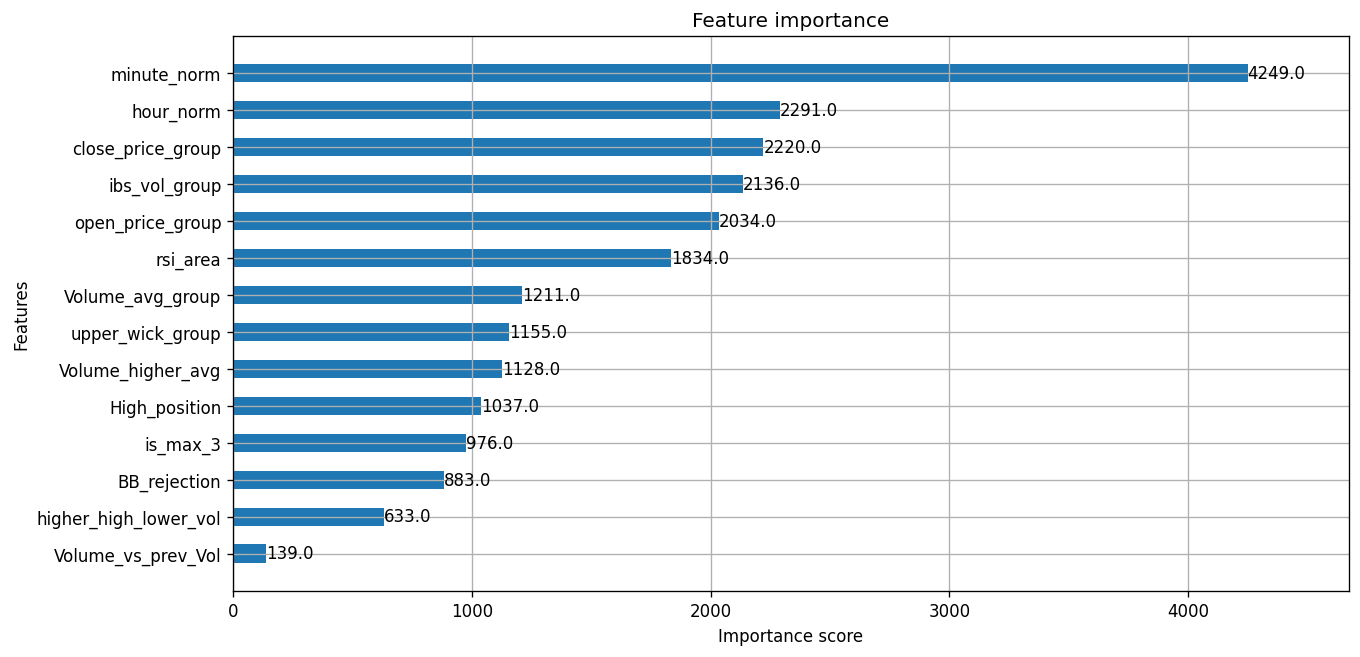

In [18]:
plot_importance(model_xgb, max_num_features=20, height=0.5)

In [19]:
proba = model_xgb.predict_proba(X_test)[:, 1]

In [20]:
print("AUC:", roc_auc_score(y_test, proba))
# print(classification_report(y_test, pred))

AUC: 0.9394379223483265


### Tối ưu threshold để có nhiều tín hiệu hơn

In [21]:
best_t = 0
best_f1 = 0

for t in np.linspace(0.01, 0.3, 60):
    pred = (proba > t).astype(int)
    f1 = f1_score(y_test, pred, zero_division=0)
    if f1 > best_f1:
        best_f1 = f1
        best_t = t

print("Best threshold:", best_t)
print("Best F1:", best_f1)

Best threshold: 0.2950847457627119
Best F1: 0.18141197497765862


In [22]:
precision, recall, thresholds = precision_recall_curve(y_test, proba)

beta = 2.0
f_beta = (1 + beta**2) * (precision * recall) / (beta**2 * precision + recall)

best_threshold = thresholds[np.argmax(f_beta)]

print("Best threshold:", best_threshold)

Best threshold: 0.7799189


In [23]:
best_tx = 0
best_score = 0

for t in np.linspace(0.01, 1, 200):
    pred = (proba > t).astype(int)
    tp = np.sum((y_test == 1) & (pred == 1))
    tpx = np.sum((y_test == 0) & (pred == 1))
    score = tp * 5 -tpx
    if score > best_score:
        best_score = score
        best_t = t

print("Best threshold:", best_t)
print("Best score:", best_score)

Best threshold: 0.9104522613065327
Best score: 236


In [24]:
threshold = 0.925
pred = (proba > threshold).astype(int)

In [25]:
result = test_data.copy()
result['predict'] = pred
result['proba'] = proba

### Try Catboost

In [26]:
from catboost import CatBoostClassifier

In [27]:
model_catb = CatBoostClassifier(
    iterations=500,       # nhiều cây -> học tốt rare-event
    depth=6,              # cây sâu -> học pattern phức tạp
    learning_rate=0.03,
    loss_function='Logloss',
    class_weights=[1, 50], # imbalance 1:50
    random_strength=0,     # ít random -> fit mạnh hơn
    l2_leaf_reg=1,
    verbose=100
)

In [28]:
model_catb.fit(X_train, y_train)

0:	learn: 0.6600335	total: 66.1ms	remaining: 33s
100:	learn: 0.2825033	total: 459ms	remaining: 1.81s
200:	learn: 0.2515889	total: 854ms	remaining: 1.27s
300:	learn: 0.2326361	total: 1.23s	remaining: 810ms
400:	learn: 0.2195993	total: 1.59s	remaining: 394ms
499:	learn: 0.2087180	total: 1.96s	remaining: 0us


In [29]:
model_catb.get_feature_importance(prettified=True)

,Feature Id,Importances
0,hour_norm,19.387733
1,minute_norm,16.968455
2,ibs_vol_group,9.894669
3,rsi_area,9.641965
4,is_max_3,9.113364
5,High_position,7.755943
6,close_price_group,7.073575
7,upper_wick_group,5.363936
8,open_price_group,5.242443
9,Volume_avg_group,3.065628


In [30]:
proba = model_catb.predict_proba(X_test)[:,1]

### Tối ưu threshold cho Catboost

In [31]:
best_tx = 0
best_score = 0

for t in np.linspace(0.01, 1, 200):
    pred = (proba > t).astype(int)
    tp = np.sum((y_test == 1) & (pred == 1))
    tpx = np.sum((y_test == 0) & (pred == 1))
    score = tp * 2 - tpx
    if score > best_score:
        best_score = score
        best_t = t

print("Best threshold:", best_t)
print("Best score:", best_score)

Best threshold: 0.9452763819095478
Best score: 49


In [32]:
threshold = 0.945
pred = (proba > threshold).astype(int)

In [33]:
result = test_data.copy()
result['predict'] = pred
result['proba'] = proba

In [34]:
result[(result.index > "2025-11-01 00:00:00") & ((result.predict == 1) | (result.is_max == 1))][['is_max', 'predict', 'proba']]

,is_max,predict,proba
Date,,,
2025-11-03 13:00:00,1,1,0.954824
2025-11-04 14:20:00,1,1,0.953849
2025-11-05 11:00:00,1,0,0.873645
2025-11-06 14:15:00,1,0,0.913231
2025-11-07 09:00:00,0,1,0.952165
2025-11-07 09:15:00,1,0,0.500417
2025-11-10 13:45:00,1,0,0.924653
2025-11-11 14:00:00,1,1,0.948555
2025-11-12 14:00:00,0,1,0.949553


### Live predict

In [35]:
import vn_realtime_stock_data.stockHistory as stockHistory
from datetime import date
from datetime import timedelta
from datetime import datetime

In [50]:
def get_stock_data(ticker, broker, back_days, reso=5):
    last_expire_date = date.today() - timedelta(days=back_days)
    timestamp_from = datetime.strptime(last_expire_date.strftime("%m/%d/%Y") + ', 00:00:0', "%m/%d/%Y, %H:%M:%S") \
        .timestamp()
    timestamp_from = int(timestamp_from)
    return stockHistory.getVN30HistoryDataByMinute(ticker=ticker, resolution=reso, broker=broker, from_=timestamp_from)

In [51]:
ticker = "VN30F1M"
live_data = get_stock_data(ticker, 'DNSE', 365)

In [52]:
live_data

,Open,High,Low,Close,Volume
Date,,,,,
2024-11-25 09:00:00,1298.6,1300.0,1298.4,1298.8,5736
2024-11-25 09:05:00,1298.8,1299.6,1298.7,1298.9,1896
2024-11-25 09:10:00,1298.8,1298.9,1297.4,1297.8,2875
2024-11-25 09:15:00,1297.9,1298.5,1297.7,1297.9,2575
2024-11-25 09:20:00,1297.9,1298.2,1296.2,1296.6,4172
...,...,...,...,...,...
2025-11-25 10:00:00,1914.3,1918.5,1914.0,1918.1,6791
2025-11-25 10:05:00,1918.1,1919.5,1917.4,1918.8,5065
2025-11-25 10:10:00,1919.0,1920.8,1918.0,1919.8,4017


In [53]:
labeled_live_data = labeling_data(live_data)

In [54]:
X_live_data = labeled_live_data[features]

In [55]:
proba = model_catb.predict_proba(X_live_data)[:,1]

In [56]:
pred = (proba > threshold).astype(int)

In [57]:
live_result = labeled_live_data.copy()
live_result['predict'] = pred
live_result['proba'] = proba

In [58]:
live_result

,Open,High,Low,Close,Volume,time_d,DayHigh,hour,minute,prev_High,...,Volume_avg_group,close_price_group,open_price_group,High_position,BB_rejection,is_max_3,hour_norm,minute_norm,predict,proba
Date,,,,,,,,,,,,,,,,,,,,,
2024-11-25 10:50:00,1298.0,1298.0,1297.3,1297.6,1551,2024-11-25,1300.9,10,50,1298.4,...,-1,0.5,0.5,-1,1,False,0.2,0.909091,0,0.000004
2024-11-25 10:55:00,1297.6,1297.7,1296.5,1296.8,2417,2024-11-25,1300.9,10,55,1298.0,...,-1,0.5,0.0,-1,1,False,0.2,1.000000,0,0.000248
2024-11-25 11:00:00,1296.6,1298.0,1296.5,1297.9,1723,2024-11-25,1300.9,11,0,1297.7,...,-1,-1.0,0.5,-1,1,False,0.4,0.000000,0,0.000002
2024-11-25 11:05:00,1297.9,1298.5,1297.6,1298.0,2517,2024-11-25,1300.9,11,5,1298.0,...,-1,-0.5,0.0,-1,1,True,0.4,0.090909,0,0.004329
2024-11-25 11:10:00,1297.9,1299.0,1297.7,1299.0,3092,2024-11-25,1300.9,11,10,1298.5,...,1,-1.0,0.5,-1,1,True,0.4,0.181818,0,0.001935
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-11-25 10:00:00,1914.3,1918.5,1914.0,1918.1,6791,2025-11-25,1922.2,10,0,1915.0,...,1,-1.0,0.5,-1,1,True,0.2,0.000000,0,0.034667
2025-11-25 10:05:00,1918.1,1919.5,1917.4,1918.8,5065,2025-11-25,1922.2,10,5,1918.5,...,-1,-1.0,0.0,-1,1,True,0.2,0.090909,0,0.549711
2025-11-25 10:10:00,1919.0,1920.8,1918.0,1919.8,4017,2025-11-25,1922.2,10,10,1919.5,...,1,-1.0,-0.5,1,1,True,0.2,0.181818,0,0.792643


In [59]:
live_result[live_result.predict == 1][['predict', 'proba']]

,predict,proba
Date,,
2024-11-27 14:00:00,1,0.949553
2024-11-29 14:25:00,1,0.976392
2024-12-17 09:00:00,1,0.960570
2024-12-18 14:20:00,1,0.953849
2024-12-18 14:25:00,1,0.973100
...,...,...
2025-11-18 14:20:00,1,0.953849
2025-11-18 14:45:00,1,0.972154
2025-11-21 14:20:00,1,0.952703
